1. Enable data augmentation, and precompute=True
2. Use lr_find() to find highest learning rate where loss is still clearly improving
3. Train last layer from precomputed activations for 1-2 epochs
4. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
5. Unfreeze all layers
6. Set earlier layers to 3x-10x lower learning rate than next higher layer
7. Use lr_find() again
8. Train full network with cycle_mult=2 until over-fitting


# Pre-requistes

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
PATH = "/home/paperspace/data/dogscats/"

In [28]:
!date

Sun Jan 21 10:05:54 EST 2018


## Get data

### Directory based structure

In [5]:
!ls {PATH}

models	sample	test1  tmp  train  valid


In [7]:
!ls {PATH}valid

cats  dogs


In [8]:
files = !ls {PATH}valid/cats | head
files

['cat.1001.jpg',
 'cat.10016.jpg',
 'cat.10026.jpg',
 'cat.10048.jpg',
 'cat.10050.jpg',
 'cat.10064.jpg',
 'cat.10071.jpg',
 'cat.10091.jpg',
 'cat.10103.jpg',
 'cat.10104.jpg']

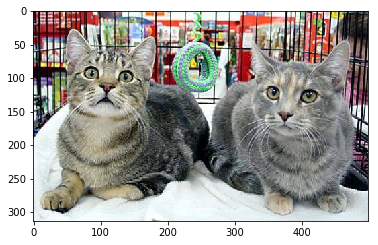

In [11]:
img = plt.imread(f'{PATH}valid/cats/{files[5]}')
plt.imshow(img)

In [12]:
# Image data (pixel_col, pixel_row, RGB)
img.shape 

(313, 499, 3)

In [22]:
def get_tfms(f_model, size): return tfms_from_model(f_model, size)

In [23]:
def get_aug_tfms(f_model, size): return tfms_from_model(f_model, size, aug_tfms=transforms_side_on, max_zoom=1.1)

In [24]:
def get_data_from_csv(f_model, sz, tfms):
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [26]:
def get_data_from_dir(f_mode, sz, tfms):
    return ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz), test_name='test1')

# Enable data augmentation, and precompute=True

## Initial model setup

In [20]:
arch=resnet34
size=224

In [42]:
data = get_data_from_dir(arch, size, get_tfms(arch, size))

In [43]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

# Use lr_find() to find highest learning rate where loss is still clearly improving

In [44]:
discovered_learning_rate = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 84%|████████▎ | 301/360 [00:05<00:01, 55.08it/s, loss=0.377] 


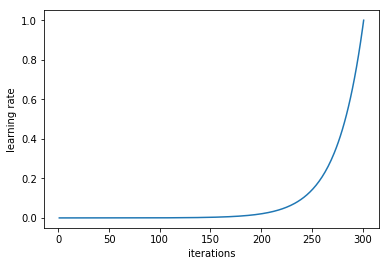

In [45]:
learn.sched.plot_lr()

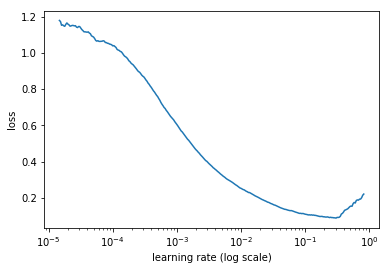

In [46]:
learn.sched.plot()

In [47]:
learning_rate = 0.01

# Train last layer from precomputed activations for 1-2 epochs

In [49]:
learn.fit(learning_rate, 3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[0.      0.04292 0.02461 0.99072]                             
[1.      0.04221 0.03091 0.98828]                             
[2.      0.02842 0.02535 0.99023]                             



## Analyse output - TBD

# Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1

In [51]:
data = get_data_from_dir(arch, size, get_aug_tfms(arch, size))

In [53]:
learn = ConvLearner.pretrained(arch, data, precompute=False)

In [54]:
learn.fit(learning_rate, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[0.      0.05512 0.03152 0.99023]                             
[1.      0.04016 0.02905 0.99121]                             
[2.      0.03431 0.02801 0.99072]                             



In [55]:
learn.save(f'last_layer_{size}')

# Train full network with cycle_mult=2 until over-fitting

### Unfreeze all layers

In [56]:
learn.unfreeze()

### Find learning rate again

In [57]:
learn = ConvLearner.pretrained(arch, data, precompute=False)

In [58]:
new_learning_rate = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 87%|████████▋ | 312/360 [01:19<00:12,  3.95it/s, loss=0.454] 

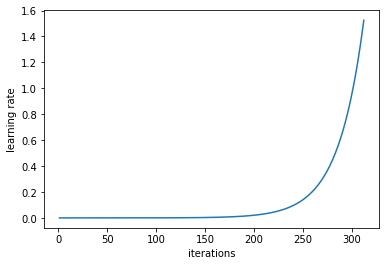

In [60]:
learn.sched.plot_lr()

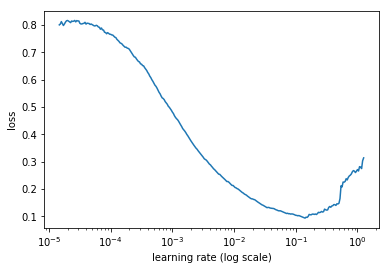

In [61]:
learn.sched.plot()

### Set earlier layers to 3x-10x lower learning rate than next higher layer

In [63]:
new_learning_rate = 0.01
learning_rates = np.array([new_learning_rate/9, new_learning_rate/3, new_learning_rate])

### Train entire network

In [64]:
learn.fit(learning_rates, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

  5%|▍         | 17/360 [00:04<01:33,  3.68it/s, loss=0.757]

Exception in thread Thread-22:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



[0.      0.04325 0.02924 0.98975]                             
[1.      0.0422  0.02615 0.99072]                             
[2.      0.03458 0.02784 0.98975]                             
[3.      0.03625 0.02448 0.99121]                             
[4.      0.03534 0.02643 0.99023]                             
[5.      0.02846 0.02501 0.9917 ]                             
[6.      0.02646 0.02504 0.99268]                             



In [65]:
learn.save(f'entire_network_{size}')

# Check accuracy

## Validation set

In [66]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds), 0)
accuracy(probs, y)

0.9925

## Test set

In [68]:
test_log_preds, test_y = learn.TTA(is_test=True)
test_probs = np.mean(np.exp(test_log_preds), 0)
print(accuracy(test_probs, test_y))

print(test_probs.shape)
print(test_probs[:4])

0.4992                                       
(12500, 2)
[[0.004   0.996  ]
 [0.99943 0.00057]
 [0.0106  0.9894 ]
 [0.      1.     ]]


# Submit to kaggle (optional)

In [69]:
isDog = test_probs[:,1]
print(isDog.shape)
print(len(isDog))
print(isDog[:5])


(12500,)
12500
[0.996   0.00057 0.9894  1.      0.99961]


In [70]:
test_ds = learn.data.test_ds
print(test_ds)
test_dl = learn.data.test_dl
test_filenames = test_dl.dataset.fnames
print(test_filenames[:5])
print(test_dl.dataset.y.max())

['test1/9885.jpg', 'test1/2701.jpg', 'test1/11231.jpg', 'test1/2964.jpg', 'test1/10651.jpg']
0.0


In [71]:
fileIds = np.array([int(f[6:f.find('.')]) for f in test_filenames])
fileIds[:5]

array([ 9885,  2701, 11231,  2964, 10651])

In [72]:
submission = np.stack([fileIds,isDog], axis=1)
submission[:5]

array([[ 9885.     ,     0.996  ],
       [ 2701.     ,     0.00057],
       [11231.     ,     0.9894 ],
       [ 2964.     ,     1.     ],
       [10651.     ,     0.99961]])

In [73]:
!pwd

/home/paperspace/fastai/courses/dl1


In [74]:
submission_file_name = 'submission1.csv'
# changed the decimal format from .5 to .10 and NO clip and moved into top 8% on kaggle (from 10%)
np.savetxt(submission_file_name, submission, fmt='%d,%.10f', header='id,label', comments='')

In [75]:
from IPython.display import FileLink
FileLink(submission_file_name)

/home/paperspace/fastai/courses/dl1/submission1.csv